In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('processed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Разобьем выборку на тест и трейн

In [3]:
from sklearn.model_selection import train_test_split

X = data.drop('HasDetections', axis=1)
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

pipe_lr = Pipeline([('scaler', MinMaxScaler()), ('lr', LogisticRegression())])
pipe_svm = Pipeline([('scaler', MinMaxScaler()), ('svm', LinearSVC())])

In [5]:
### Обучаем модели на трейне
pipe_lr.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', LinearSVC())])

In [9]:
pipe_lr.score(X_test, y_test).round(3), pipe_svm.score(X_test, y_test).round(3)

(0.843, 0.84)

Постройте ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`. 

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$
Таким образом мы можем перевести выходы SVM в отрезок [0;1] и попробовать интерпретировать новые числа как вероятности, чтобы изобразить калибровочную кривую. При таком преобразовании пропорции внутри первоначально отрицательных и внутри положительных чисел сохраняются.

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc 

In [16]:
### С изображением рок-кривой для ЛогРега не будет проблем:

fpr, tpr, tresholds = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1])


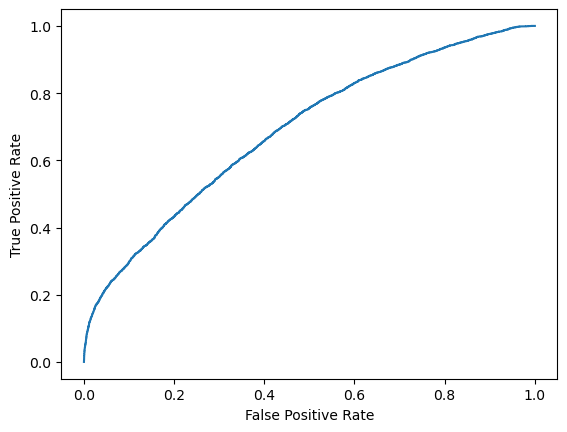

In [17]:
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [22]:
auc(fpr, tpr).round(3)

0.689

In [34]:
### А для того, чтобы построить и изобразить рок-кривую для SVM, придется
### в начале преобразовать выходы pipe_svm.decision_function

pipe_svm_decision = pipe_svm.decision_function(X_test)

max_value = pipe_svm_decision.max()
min_value = pipe_svm_decision.min()

pipe_svm_proba = []
for value in pipe_svm_decision:
    if value == max_value:
        pipe_svm_proba.append(1)
    elif value == min_value:
        pipe_svm_proba.append(0)
    else:
        if value < 0:
            pipe_svm_proba.append(abs(value - min_value) * 0.5 / abs(min_value))
        else:
            pipe_svm_proba.append(abs(value - max_value) * 0.5 / abs(max_value) + 0.5)
        


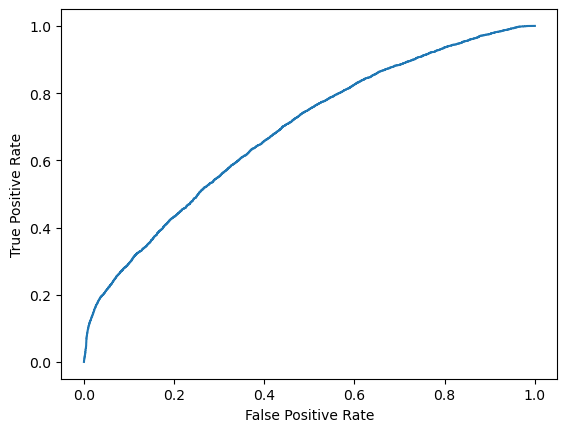

In [35]:
fpr, tpr, tresholds = roc_curve(y_test, pipe_svm_proba)

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [36]:
auc(fpr, tpr).round(3)

0.688

Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

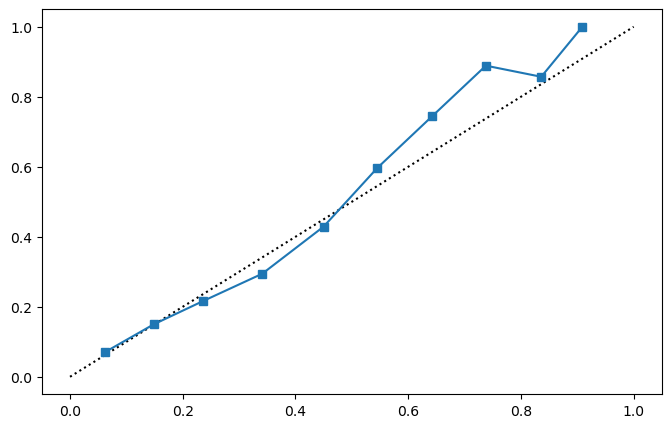

In [40]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

### Предсказания модели на тесте и соответствующая калибровочная кривая
prob_pos = pipe_lr.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg")



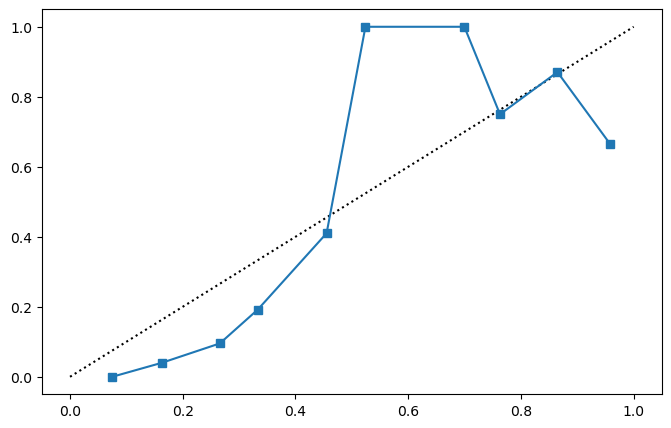

In [41]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

### Предсказания модели на тесте и соответствующая калибровочная кривая
prob_pos = pipe_svm_proba
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="svm")



**Какая калибровочная кривая ближе к диагонали?  Откалибруйте SVM способом как в практике и изобразите новую кривую!

In [ ]:
### Калибровка

from sklearn.calibration import CalibratedClassifierCV

calibrated = CalibratedClassifierCV(pipe_svm, method='sigmoid', cv=5)
calibrated.fit(X_train, y_train)

prob_pos = calibrated.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)


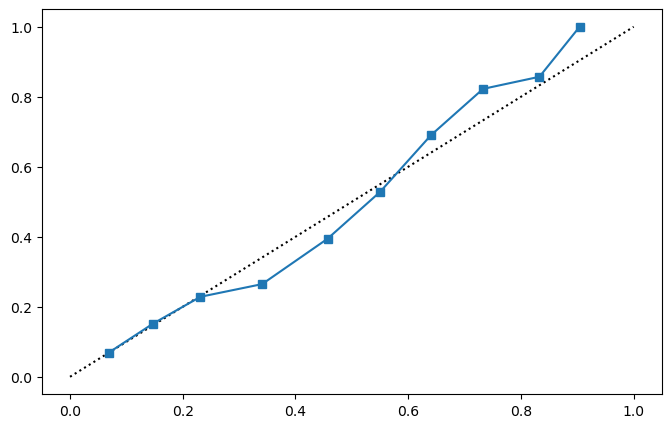

In [44]:
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="calibrated svm")

In [45]:
### Калибровка

from sklearn.calibration import CalibratedClassifierCV

calibrated = CalibratedClassifierCV(pipe_svm, method='isotonic', cv=5)
calibrated.fit(X_train, y_train)

prob_pos = calibrated.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)


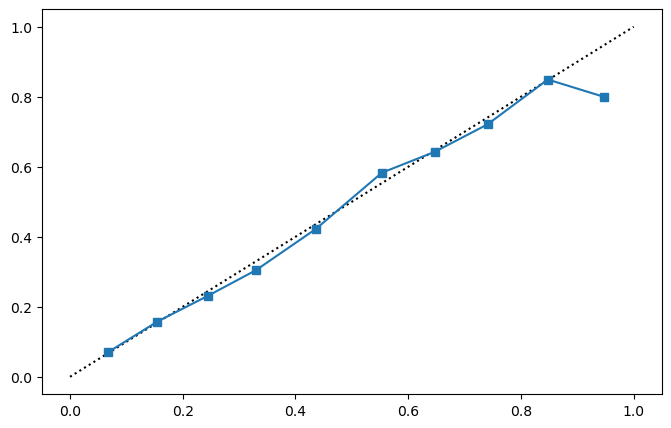

In [46]:
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="calibrated svm")